In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import networkx as nx

from models.building_model import BuildingModel
from models.heat_pump import HeatPump
from models.hyst_controller import HystController
from models.weather_model import LocalWeather

%matplotlib widget


In [2]:
np.set_printoptions(precision=4, linewidth=200)
pd.options.display.max_columns = 20
pd.options.display.width = 300

In [3]:
building = BuildingModel('building')
heatpump = HeatPump('heatpump')
controller = HystController('controller')
weather = LocalWeather('weather')

In [4]:
models = [weather, controller, heatpump, building]

state_names = []
for model in models:
    model.state_selector = []
    for state_name in model.states:
        state_names.append(model.name + '_' + state_name)
        model.state_selector.append(state_names.index(model.name + '_' + state_name))

output_names = []
for model in models:
    model.output_selector = []
    for output_name in model.outputs:
        output_names.append(model.name +  '_' + output_name)
        model.output_selector.append(output_names.index(model.name + '_' + output_name))

In [5]:
state = np.hstack([m.init() for m in models])
output = np.full(len(output_names), np.nan)

In [6]:
G = nx.DiGraph()
G.add_nodes_from(models)

In [7]:
def connect(model1, model2, *connections, time_shifted=False, init_values=None):
    if not hasattr(model2, 'input_selector'):
        model2.input_selector =  [np.nan]*len(model2.inputs)  # [[np.nan] * len(building.inputs)] * 2

    for connection in connections:
        if type(connection) == str:
            connection = (connection, connection)
        attribute_out, attribute_in = connection
        
        model_attribute_index = model2.inputs.index(attribute_in)
        world_output_index = output_names.index(model1.name + '_' + attribute_out)

        if model2.input_selector[model_attribute_index] is np.nan or model2.input_selector[model_attribute_index] is world_output_index:
            model2.input_selector[model_attribute_index] = world_output_index
        else:
            raise ValueError(f'Trying to set multiple inputs for {model2.name} {attribute_in}')
        
        if time_shifted: # initialize time shifted connection
            output[output_names.index(model1.name + '_' + attribute_out)] = init_values[attribute_out]


        G.add_edge(model1, model2, name=connection, time_shifted=time_shifted)



In [8]:
# collect data of models
# track_df_columns = []

# def track(model, *track_outputs):

#     if not hasattr(model, 'track_selector'):
#         model.track_selector =  [np.nan]*len(track_outputs)

In [9]:
connect(weather, building, ('T_air', 'T_amb'), 'apparent_zenith', 'azimuth', 'dni', 'dhi', 'ghi')
connect(weather, heatpump, ('T_air', 'T_source'))
connect(heatpump, building, ('dot_Q_hp', 'dot_Q_heat'))
connect(controller, heatpump, ('on', 'on'))

connect(building, heatpump, ('T_room1', 'T_sink'), time_shifted=True, init_values={'T_room1': 21})
connect(building, controller, ('T_room1', 'T_is'), time_shifted=True, init_values={'T_room1': 21})

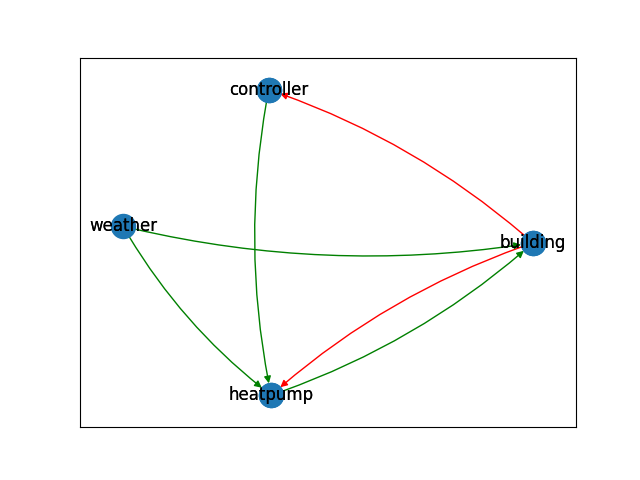

In [10]:
plt.figure()
pos=nx.spring_layout(G)

edges_same_time    = [(u,v) for u, v, d in G.edges(data=True) if not d['time_shifted']]
edges_time_shifted = [(u,v) for u, v, d in G.edges(data=True) if d['time_shifted']]
node_labels = {m:m.name for m in G.nodes}

G_current = G.edge_subgraph(edges_same_time)
G_shifted = G.edge_subgraph(edges_time_shifted)

# nx.draw_networkx(G, pos, edgelist=edges_same_time, edge_color="green", connectionstyle='arc3, rad = 0.1', labels=node_labels)
# nx.draw_networkx(G, pos, edgelist=edges_time_shifted, edge_color="red", connectionstyle='arc3, rad = 0.1', labels=node_labels)

nx.draw_networkx(G_shifted, pos, edgelist=edges_time_shifted, edge_color="red", connectionstyle='arc3, rad = 0.1', labels=node_labels)
nx.draw_networkx(G_current, pos, edgelist=edges_same_time, edge_color="green", connectionstyle='arc3, rad = 0.1', labels=node_labels)

plt.show()

In [11]:
if not nx.is_directed_acyclic_graph(G_current):
    raise ValueError('There must be a cycle in the connections')

In [12]:
# Reverse time shifted edges, to ensue, that models containing input for another model in the next step are steped last.
# The concept has to be double checked
G_direction_check = G_current.copy()
G_direction_check.add_edges_from([(v, u) for u, v in G_shifted.edges])

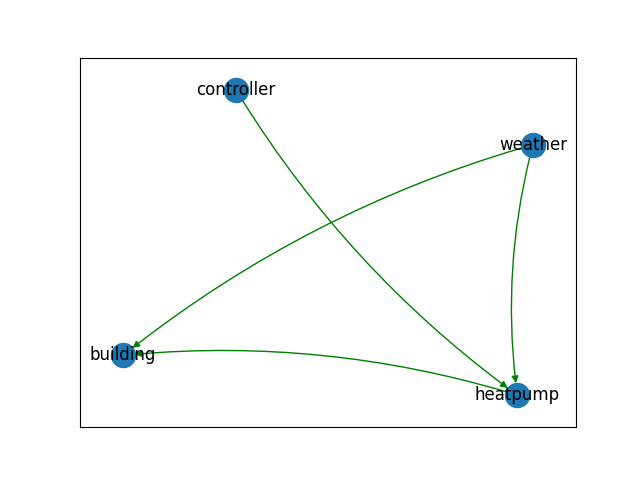

In [13]:
plt.figure()
pos=nx.spring_layout(G)

node_labels = {m:m.name for m in G.nodes}

nx.draw_networkx(G_direction_check, pos, edgelist=edges_same_time, edge_color="green", connectionstyle='arc3, rad = 0.1', labels=node_labels)

plt.show()

In [14]:
model_execution_list = list(nx.topological_sort(G_direction_check))

In [15]:
model_execution_list

In [16]:
times = pd.date_range('2021-01-01 00:00:00', '2021-01-03 00:00:00', freq='1min', tz='UTC+01:00')

df = pd.DataFrame([], index=times, columns=output_names, dtype=float)

deltas = [pd.Timedelta(m.delta_t, 'sec') for m in model_execution_list]
prev_time = [pd.to_datetime('1990-01-01 00:00:00+01:00') for _ in model_execution_list]

for time in times:

    step_models = [[i, m] for i, [m, p, d] in enumerate(zip(model_execution_list, prev_time, deltas)) if time-p >= d]
    
    for i, model in step_models:
        # print(f'{model.name:10}\t{prev_t}\t{time}')
        prev_time[i] = time

        i_inp = getattr(model, 'input_selector', 0) # maybe change default below
        output_i = output[i_inp]
        
        i_state = getattr(model, 'state_selector', 0)
        state_i = state[i_state]

        state[model.state_selector], output[model.output_selector] = model.step(time, state_i, output_i)

        df.loc[time, [model.name + '_' + o for o in model.outputs]] = output[model.output_selector]
        
        # print(model.name, time)

        # print('states', state_i)
        # if model.inputs:
        #     print('inputs', list(zip(list(model.inputs), list(output_i))))
        # print('outputs', list(zip(list(model.outputs), list(output[0][model.output_selector]))))
        # print('states', list(zip(list(model.states), list(state[model.state_selector]))))
        # print()
        # print(pd.DataFrame(output, columns=output_names))

        # print(output_names)
        # print(output)
        
        # print()

In [17]:
# df #.info()

In [32]:
times1 = pd.date_range('2021-01-01 00:00:00', '2021-01-03 00:00:00', freq='1min', tz='UTC+01:00')




True

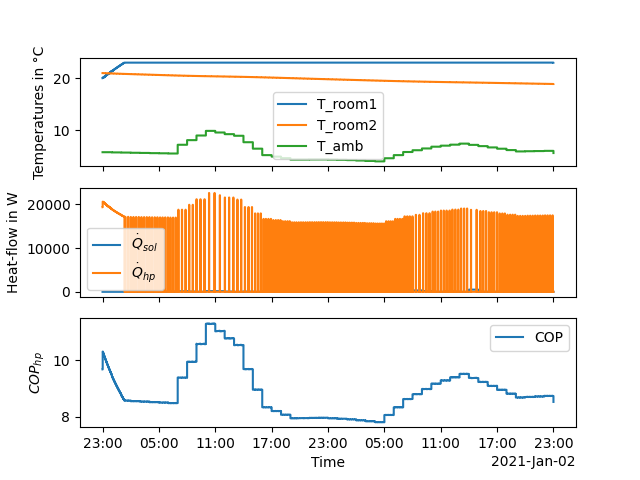

In [18]:
df.interpolate('ffill', inplace=True)
dtindex = df.index 
fig, ax = plt.subplots(3, sharex=True)
# Roomtemperatures
ax[0].plot(dtindex, df['building_T_room1'], label='T_room1', drawstyle='steps-post')
ax[0].plot(dtindex, df['building_T_room2'], label='T_room2', drawstyle='steps-post')
ax[0].plot(dtindex, df['weather_T_air'], label='T_amb', drawstyle='steps-post')
ax[0].legend()
ax[0].set_ylabel('Temperatures in °C')

ax[1].plot(dtindex, df['building_dot_Q_sol'], label='$\dot{Q}_{sol}$', drawstyle='steps-post')
ax[1].plot(dtindex, df['heatpump_dot_Q_hp'], label='$\dot{Q}_{hp}$', drawstyle='steps-post')
ax[1].legend()
ax[1].set_ylabel('Heat-flow in W')

ax[2].plot(dtindex, df['heatpump_cop'], label='COP', drawstyle='steps-post')
ax[2].legend()
ax[2].set_ylabel('$COP_{hp}$')

ax[-1].set_xlabel('Time')
ax[-1].xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax[-1].xaxis.get_major_locator(),))